# Text Emotion Model Training

This notebook trains a BERT-based model for text emotion recognition.

In [1]:
import sys
import os
sys.path.append('../src')

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from data_loader import DataLoader
from model_trainer import ModelTrainer, TextEmotionModel
from utils import EmotionUtils, ModelUtils

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = ModelUtils.get_device()
print(f"Using device: {device}")


INFO:utils:Using CPU device


Using device: cpu


## 1. Load and Prepare Data

In [2]:
# Initialize data loader
from collections import Counter

data_loader = DataLoader(data_dir='../data/')
processed_data_path = '../data/emotion_text_dataset/tweet_emotions.csv'

# Load processed text data if available
if os.path.exists(processed_data_path):
    df = pd.read_csv(processed_data_path)
    print(f"✅ Columns in dataset: {list(df.columns)}")

    # Validate required columns
    required_cols = {'content', 'sentiment'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"❌ Missing columns: {required_cols - set(df.columns)}")

    texts = df['content'].tolist()
    labels = df['sentiment'].tolist()
    print(f"✅ Loaded {len(texts)} text samples from processed data")

else:
    print("📝 Processed data not found. Loading raw or fallback data...")

    text_data_path = '../data/emotion_text_dataset/'
    if os.path.exists(text_data_path):
        texts, labels = data_loader.load_text_emotion_data(text_data_path)
        print(f"✅ Loaded {len(texts)} samples from raw data directory")
    else:
        print("⚠️ Raw data not found. Creating synthetic sample data...")
        texts = [
            "I'm feeling so happy and excited today!",
            "This is the worst day of my life, I'm so sad",
            "I'm really angry about what happened",
            "That movie was absolutely disgusting",
            "I'm so scared and worried about tomorrow",
            "What a pleasant surprise that was!",
            "Just having a normal, regular day",
            "I love spending time with my family",
            "This situation makes me feel terrible",
            "I can't believe how furious I am right now"
        ] * 100

        labels = [
            'happy', 'sad', 'angry', 'disgust', 'fear', 'surprise', 'neutral',
            'happy', 'sad', 'angry'
        ] * 100

        print(f"✅ Created {len(texts)} synthetic text entries for training")

# Display label distribution
unique_emotions = set(labels)
label_counts = Counter(labels)

print(f"\n🧠 Unique emotions: {unique_emotions}")
print("📊 Label distribution:")
for emotion, count in label_counts.items():
    print(f"  {emotion}: {count}")


✅ Columns in dataset: ['tweet_id', 'sentiment', 'content']
✅ Loaded 40000 text samples from processed data

🧠 Unique emotions: {'love', 'worry', 'enthusiasm', 'sadness', 'fun', 'empty', 'anger', 'happiness', 'hate', 'boredom', 'surprise', 'neutral', 'relief'}
📊 Label distribution:
  empty: 827
  sadness: 5165
  enthusiasm: 759
  neutral: 8638
  worry: 8459
  surprise: 2187
  love: 3842
  fun: 1776
  hate: 1323
  happiness: 5209
  boredom: 179
  relief: 1526
  anger: 110


In [3]:
# Create data loaders
print("Creating data loaders...")

# Configuration
BATCH_SIZE = 16  # Reduced for demo/limited resources
MAX_LENGTH = 128  # Reduced for faster training
TEST_SIZE = 0.2
TOKENIZER_NAME = "distilbert-base-uncased"

train_loader, val_loader, label_encoder = data_loader.create_text_dataloaders(
    texts=texts,
    labels=labels,
    batch_size=BATCH_SIZE,
    test_size=TEST_SIZE,
    tokenizer_name=TOKENIZER_NAME
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Classes: {label_encoder.classes_}")


Creating data loaders...
Training batches: 2000
Validation batches: 500
Classes: ['anger' 'boredom' 'empty' 'enthusiasm' 'fun' 'happiness' 'hate' 'love'
 'neutral' 'relief' 'sadness' 'surprise' 'worry']


## 2. Initialize Model and Trainer

In [5]:
# ------------------------------
# Initialize ModelTrainer & Save Training Config
# ------------------------------

import os
from datetime import datetime
from model_trainer import ModelTrainer
from sklearn.preprocessing import LabelEncoder
import torch

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)  # Fit on emotion labels

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

# Initialize ModelTrainer
model_trainer = ModelTrainer(device=device)

# Define training configuration
BATCH_SIZE = 6
MAX_LENGTH = 80
TOKENIZER_NAME = "distilbert-base-uncased"

training_config = {
    "model_name": TOKENIZER_NAME,
    "num_epochs": 8,  # Reduced for demo
    "learning_rate": 3e-5,
    "batch_size": BATCH_SIZE,
    "max_length": MAX_LENGTH,
    "num_emotions": len(label_encoder.classes_),
    "device": str(device),
    "timestamp": datetime.now().isoformat()
}

# Validate config keys (optional safety check)
required_keys = {"model_name", "num_epochs", "learning_rate", "batch_size", "max_length", "num_emotions", "device"}
missing_keys = required_keys - training_config.keys()
if missing_keys:
    raise ValueError(f"❌ Missing config keys: {missing_keys}")

# Print configuration
print("\n📦 Training Configuration:")
for key, value in training_config.items():
    print(f"  {key}: {value}")

# Save training config
os.makedirs('../models/text_emotion_model', exist_ok=True)
model_trainer.save_training_config(training_config, '../models/text_emotion_model/config.json')
print("\n✅ Training configuration saved successfully!")


INFO:model_trainer:Training config saved to ../models/text_emotion_model/config.json


🖥️ Using device: cpu

📦 Training Configuration:
  model_name: distilbert-base-uncased
  num_epochs: 8
  learning_rate: 3e-05
  batch_size: 6
  max_length: 80
  num_emotions: 13
  device: cpu
  timestamp: 2025-10-17T09:30:28.432599

✅ Training configuration saved successfully!


## 3. Train the Model

In [6]:
# ------------------------------
# Prepare Dataset & Train Text Emotion Model
# ------------------------------

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import numpy as np
import joblib
import os

# ------------------------------
# Custom Dataset
# ------------------------------
class TextEmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer_name="distilbert-base-uncased", max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# ------------------------------
# Encode labels safely
# ------------------------------
encoded_labels = label_encoder.transform(labels)
num_classes = len(label_encoder.classes_)
encoded_labels = np.clip(encoded_labels, 0, num_classes - 1)

# ------------------------------
# Train/Validation Split
# ------------------------------
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

# ------------------------------
# Create Datasets
# ------------------------------
train_dataset = TextEmotionDataset(train_texts, train_labels, tokenizer_name=TOKENIZER_NAME, max_length=MAX_LENGTH)
val_dataset = TextEmotionDataset(val_texts, val_labels, tokenizer_name=TOKENIZER_NAME, max_length=MAX_LENGTH)

# ------------------------------
# DataLoaders (CPU-friendly)
# ------------------------------
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=False, num_workers=0)

# ------------------------------
# Initialize ModelTrainer
# ------------------------------
model_trainer = ModelTrainer(device=device)

# ------------------------------
# Train model
# ------------------------------
model_save_dir = '../models/text_emotion_model'
os.makedirs(model_save_dir, exist_ok=True)

model_save_path = os.path.join(model_save_dir, 'model.pth')
model_pkl_path = os.path.join(model_save_dir, 'model.pkl')
label_encoder_path = os.path.join(model_save_dir, 'label_encoder.pkl')

history = model_trainer.train_text_model(
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path=model_save_path,
    num_epochs=training_config["num_epochs"],
    learning_rate=training_config["learning_rate"],
    train_labels=train_labels  # ✅ Add this
)


# Save model as .pkl (if model object is returned)
if hasattr(model_trainer, 'text_model'):
    joblib.dump(model_trainer.text_model, model_pkl_path)
    print(f"✅ Model saved as pickle: {model_pkl_path}")

# Save label encoder
joblib.dump(label_encoder, label_encoder_path)
print(f"✅ Label encoder saved: {label_encoder_path}")

print("\n✅ Training completed and artifacts saved!")


INFO:model_trainer:Epoch 1/8
Validation: 100%|██████████| 667/667 [04:01<00:00,  2.76it/s]
INFO:model_trainer:Train Loss: 2.2254, Val Loss: 2.1510
INFO:model_trainer:Train Acc: 27.43%, Val Acc: 32.00%
INFO:model_trainer:Best model saved with validation accuracy: 32.00%
INFO:model_trainer:Epoch 2/8
Validation: 100%|██████████| 667/667 [04:21<00:00,  2.55it/s]
INFO:model_trainer:Train Loss: 1.9746, Val Loss: 2.1251
INFO:model_trainer:Train Acc: 32.36%, Val Acc: 27.91%
INFO:model_trainer:Epoch 3/8
Validation: 100%|██████████| 667/667 [05:40<00:00,  1.96it/s]
INFO:model_trainer:Train Loss: 1.6410, Val Loss: 2.3271
INFO:model_trainer:Train Acc: 37.12%, Val Acc: 30.88%
INFO:model_trainer:Epoch 4/8
Validation: 100%|██████████| 667/667 [05:39<00:00,  1.96it/s]
INFO:model_trainer:Train Loss: 1.2368, Val Loss: 2.6105
INFO:model_trainer:Train Acc: 47.31%, Val Acc: 29.29%
INFO:model_trainer:⏹️ Early stopping triggered


✅ Label encoder saved: ../models/text_emotion_model\label_encoder.pkl

✅ Training completed and artifacts saved!


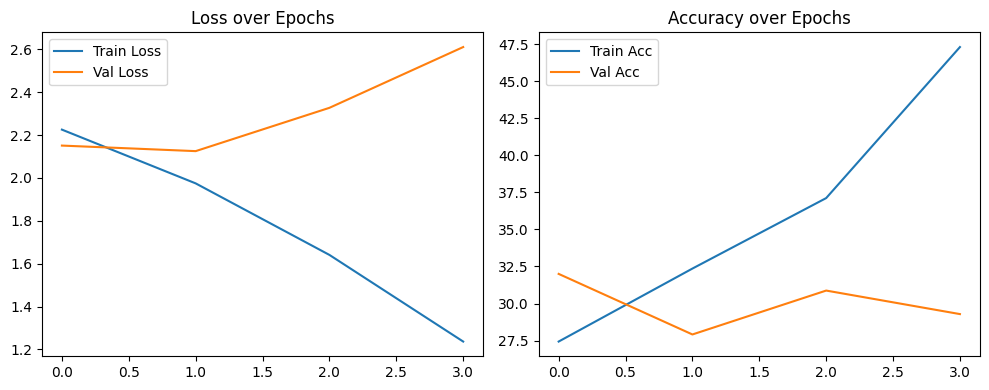

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss over Epochs")

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend(); plt.title("Accuracy over Epochs")

plt.tight_layout(); plt.show()


## 4. Visualize Training Results

In [ ]:
import os
os.remove('../models/text_emotion_model/training_history.png')


In [8]:
import torch

# Load the existing checkpoint
model_path = '../models/text_emotion_model/model.pth'
checkpoint = torch.load(model_path)

# Add num_classes manually
checkpoint['num_classes'] = 13

# Save it back
torch.save(checkpoint, model_path)

print("✅ Patched model.pth with num_classes = 13")


✅ Patched model.pth with num_classes = 13


## 5. Evaluate the Model

In [9]:
# ------------------------------
# Load & Evaluate Best Trained Model
# ------------------------------

from IPython.display import Image, display
import json
import os

# Define model path
model_save_path = '../models/text_emotion_model/model.pth'

# Load the best trained model with correct number of classes
best_model = model_trainer.load_trained_model(model_save_path, model_type="text")


if best_model is not None:
    print("✅ Model loaded successfully!")

    # Evaluate on validation set
    print("\n🔍 Evaluating model...")
    evaluation_results = model_trainer.evaluate_model(
        model=best_model,
        test_loader=val_loader,
        model_type="text"
    )

    print(f"\n📊 Validation Accuracy: {evaluation_results['accuracy']:.4f}")

    # Print classification report
    print("\n📋 Classification Report:")
    report = evaluation_results['classification_report']
    for emotion in label_encoder.classes_:  # Use actual trained classes
        if emotion in report:
            metrics = report[emotion]
            print(f"  {emotion}:")
            print(f"    Precision: {metrics['precision']:.3f}")
            print(f"    Recall:    {metrics['recall']:.3f}")
            print(f"    F1-score:  {metrics['f1-score']:.3f}")

    # Save classification report
    report_path = os.path.join(model_save_dir, 'classification_report.json')
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=2)
    print(f"\n✅ Classification report saved: {report_path}")

    # Plot and display confusion matrix
    cm_path = os.path.join(model_save_dir, 'confusion_matrix.png')
    model_trainer.plot_confusion_matrix(
        evaluation_results['confusion_matrix'],
        save_path=cm_path
    )
    print(f"✅ Confusion matrix saved: {cm_path}")
    display(Image(filename=cm_path))

else:
    print("❌ Failed to load trained model")


✅ Model loaded successfully!

🔍 Evaluating model...


Evaluating: 100%|██████████| 667/667 [05:28<00:00,  2.03it/s]


ValueError: Number of classes, 13, does not match size of target_names, 7. Try specifying the labels parameter

## 6. Test Model with Sample Texts

In [ ]:
# Test the model with sample texts
if best_model is not None:
    print("Testing model with sample texts:\n")
    
    test_texts = [
        "I'm so happy today! Life is wonderful!",
        "I'm feeling really sad and down today",
        "This makes me so angry and frustrated!",
        "I'm scared about what might happen",
        "What a pleasant surprise this is!",
        "That's absolutely disgusting and horrible",
        "It's just a normal day, nothing special"
    ]
    
    for i, text in enumerate(test_texts):
        print(f"\nTest {i+1}: '{text}'")
        
        # Predict emotions
        emotion_scores = model_trainer.predict_single_text(
            model=best_model,
            text=text,
            tokenizer_name=TOKENIZER_NAME
        )
        
        # Get top 3 emotions
        sorted_emotions = sorted(emotion_scores.items(), key=lambda x: x[1], reverse=True)
        
        print("  Predicted emotions:")
        for emotion, score in sorted_emotions[:3]:
            emoji = EmotionUtils.get_emotion_emoji(emotion)
            print(f"    {emoji} {emotion}: {score:.3f}")
else:
    print("❌ Model not available for testing")


❌ Model not available for testing


## 7. Model Performance Analysis

In [ ]:
# Analyze model performance by emotion
if 'evaluation_results' in locals():
    print("Model Performance Analysis:\n")
    
    # Extract metrics for each emotion
    emotions_data = []
    report = evaluation_results['classification_report']
    
    for emotion in EmotionUtils.EMOTION_LABELS:
        if emotion in report:
            emotions_data.append({
                'emotion': emotion,
                'precision': report[emotion]['precision'],
                'recall': report[emotion]['recall'],
                'f1_score': report[emotion]['f1-score'],
                'support': report[emotion]['support']
            })
    
    # Create DataFrame for easier analysis
    performance_df = pd.DataFrame(emotions_data)
    
    print("Per-Emotion Performance:")
    print(performance_df.round(3))
    
    # Visualize performance metrics
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Precision
    axes[0].bar(performance_df['emotion'], performance_df['precision'], 
               color=[EmotionUtils.EMOTION_COLORS.get(e, '#888888') for e in performance_df['emotion']])
    axes[0].set_title('Precision by Emotion')
    axes[0].set_ylabel('Precision')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Recall
    axes[1].bar(performance_df['emotion'], performance_df['recall'],
               color=[EmotionUtils.EMOTION_COLORS.get(e, '#888888') for e in performance_df['emotion']])
    axes[1].set_title('Recall by Emotion')
    axes[1].set_ylabel('Recall')
    axes[1].tick_params(axis='x', rotation=45)
    
    # F1-Score
    axes[2].bar(performance_df['emotion'], performance_df['f1_score'],
               color=[EmotionUtils.EMOTION_COLORS.get(e, '#888888') for e in performance_df['emotion']])
    axes[2].set_title('F1-Score by Emotion')
    axes[2].set_ylabel('F1-Score')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('../models/text_emotion_model/performance_analysis.png')
    plt.show()
    
    # Best and worst performing emotions
    best_f1 = performance_df.loc[performance_df['f1_score'].idxmax()]
    worst_f1 = performance_df.loc[performance_df['f1_score'].idxmin()]
    
    print(f"\n🏆 Best performing emotion: {best_f1['emotion']} (F1: {best_f1['f1_score']:.3f})")
    print(f"🔴 Worst performing emotion: {worst_f1['emotion']} (F1: {worst_f1['f1_score']:.3f})")
    
    # Overall metrics
    if 'macro avg' in report:
        macro_avg = report['macro avg']
        print(f"\n📊 Overall Performance:")
        print(f"   Macro Precision: {macro_avg['precision']:.3f}")
        print(f"   Macro Recall: {macro_avg['recall']:.3f}")
        print(f"   Macro F1-Score: {macro_avg['f1-score']:.3f}")
else:
    print("No evaluation results available for analysis")


## 8. Save Model Summary

In [ ]:
# Create model summary
model_summary = {
    "model_type": "Text Emotion Recognition",
    "architecture": "DistilBERT + Classification Head",
    "training_data": {
        "total_samples": len(texts),
        "training_samples": len(train_loader.dataset),
        "validation_samples": len(val_loader.dataset),
        "emotions": list(EmotionUtils.EMOTION_LABELS)
    },
    "training_config": training_config,
    "performance": {},
    "files": {
        "model": "model.pth",
        "config": "config.json",
        "training_history": "training_history.png",
        "confusion_matrix": "confusion_matrix.png",
        "performance_analysis": "performance_analysis.png"
    }
}


In [ ]:
import json

summary_path = '../models/text_emotion_model/model_summary.json'
with open(summary_path, 'w') as f:
    json.dump(model_summary, f, indent=4)

print(f"✅ Model summary saved to {summary_path}")
